# Agent Middleware and Context Engineering


As agents run longer, the message list grows. Tool calls, tool results, intermediate reasoning — it all accumulates. Eventually the model's context window fills up or (more commonly) the model's performance degrades because it's attending to hundreds of irrelevant earlier messages.

This is the **context engineering** problem. Middleware gives us composable hooks into the agent loop to manage this.

In this notebook:
1. `SummarizationMiddleware` — compress old messages
2. `HumanInTheLoopMiddleware` — approve risky tool calls
3. `ModelCallLimitMiddleware` — prevent runaway loops
4. Stacking multiple middleware
5. Observability with LangSmith
6. Writing custom middleware (preview)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)
# Expects: OPENROUTER_API_KEY, SERPAPI_API_KEY
# Optional: LANGSMITH_API_KEY

True

In [2]:
from langchain_openai import ChatOpenAI

# Shared LLM config for this notebook — used by create_agent below
llm = ChatOpenAI(
    model="openai/gpt-4.1",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)
llm_mini = ChatOpenAI(
    model="openai/gpt-4.1-mini",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

In [3]:
# Shared tools for this notebook
from langchain_core.tools import tool
from langchain_community.utilities import SerpAPIWrapper
from langchain_core.messages import HumanMessage


@tool
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"


@tool
def get_current_date() -> str:
    """Get today's date."""
    from datetime import date
    return str(date.today())


@tool
def web_search(query: str) -> str:
    """Search the web for real-time information."""
    serpapi = SerpAPIWrapper()
    return serpapi.run(query)

## 1. Conversation compression with `SummarizationMiddleware`

This middleware monitors the message list and automatically summarizes older messages when a threshold is reached. It keeps the most recent messages intact while compressing history into a summary.

**When it triggers:** token count, message count, or fraction of context window

**What it does:** replaces old messages with a summary, keeps recent N messages

In [4]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver

agent_with_summarization = create_agent(
    model=llm,
    tools=[web_search, calculator, get_current_date],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model=llm_mini,            # Cheap model for summaries
            trigger=("tokens", 1000),   # Trigger when context hits 1,000 tokens
            keep=("messages", 2),      # Keep the 2 most recent messages
        ),
    ],
)

print("Agent created with SummarizationMiddleware")

Agent created with SummarizationMiddleware


In [5]:
config = {"configurable": {"thread_id": "summarization-demo"}}

# Run a long multi-turn conversation to trigger summarization
questions = [
    "What is LangGraph and how does it relate to LangChain?",
    "What's 2^16 + 3^10?",
    "Talk to me about Aristotle",
    "What is 1234 * 5678?",
    "Give me a poem for each of the planets in our solar system",
    "What is the capital of France? Of Germany? Of Switzerland?",
]

for i, question in enumerate(questions, 1):
    print(f"\n{'='*60}")
    print(f"Turn {i}: {question}")
    print(f"{'='*60}")
    result = agent_with_summarization.invoke(
        {"messages": [HumanMessage(content=question)]},
        config=config,
    )
    # Show message count to track growth
    print(f"Messages in state: {len(result['messages'])}")
    print(f"Last response: {result['messages'][-1].content[:150]}...")


Turn 1: What is LangGraph and how does it relate to LangChain?
Messages in state: 2
Last response: **LangGraph** is an open-source Python framework designed to simplify the development of complex, stateful AI applications using **graphs of language ...

Turn 2: What's 2^16 + 3^10?
Messages in state: 7
Last response: It looks like there was a calculation error. Let me recalculate:

- 2^16 = 65,536
- 3^10 = 59,049

So, 2^16 + 3^10 = 65,536 + 59,049 = 124,585....

Turn 3: Talk to me about Aristotle
Messages in state: 9
Last response: Absolutely! Aristotle is one of the most influential figures in Western philosophy and science. Here’s an overview of his life, ideas, and enduring le...

Turn 4: What is 1234 * 5678?
Messages in state: 4
Last response: The product of 1234 and 5678 is 7,006,652.

If you have any more questions or need further explanations on LangGraph, LangChain, or other topics, feel...

Turn 5: Give me a poem for each of the planets in our solar system
Messages in state: 6

In [6]:
# Inspect the state — look for a summary message replacing older messages
for i, msg in enumerate(result["messages"][:10]):
    print(f"Message {i}: [{type(msg).__name__}] {msg.content[:120]}...")

print(f"\n... ({len(result['messages'])} total messages)")

Message 0: [HumanMessage] Here is a summary of the conversation to date:

## SESSION INTENT
The user's primary goal is to understand what LangGrap...
Message 1: [AIMessage] ...
Message 2: [ToolMessage] 7006652...
Message 3: [AIMessage] The product of 1234 and 5678 is 7,006,652.

If you have any more questions or need further explanations on LangGraph, La...
Message 4: [HumanMessage] Give me a poem for each of the planets in our solar system...
Message 5: [AIMessage] Certainly! Here is a short, original poem for each planet in our solar system:

---

**Mercury**  
Winged messenger clos...
Message 6: [HumanMessage] What is the capital of France? Of Germany? Of Switzerland?...
Message 7: [AIMessage] Here are the capitals of the countries you asked about:

- The capital of France is **Paris**.
- The capital of Germany ...

... (8 total messages)


## 2. Human-in-the-loop with `HumanInTheLoopMiddleware`

For high-stakes operations (sending emails, making purchases, modifying data), you want human approval before the tool executes.

The middleware **interrupts** the agent, presents the pending tool call, and waits for a human decision: approve, edit, or reject.

In [7]:
from langchain.agents.middleware import HumanInTheLoopMiddleware


@tool
def read_email(email_id: str) -> str:
    """Read an email by ID. This is a safe, read-only operation."""
    emails = {
        "1": "From: boss@company.com — Meeting moved to 3pm tomorrow.",
        "2": "From: hr@company.com — Please submit your timesheet by Friday.",
        "3": "From: client@external.com — Can we reschedule the demo?",
    }
    return emails.get(email_id, f"Email {email_id} not found.")


@tool
def send_email(recipient: str, subject: str, body: str) -> str:
    """Send an email. This action cannot be undone."""
    return f"Email sent to {recipient}: {subject}"


hitl_agent = create_agent(
    model=llm,
    tools=[read_email, send_email],
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email": {  # Requires approval
                    "allowed_decisions": ["approve", "edit", "reject"],
                },
                "read_email": False,  # Auto-approved, no interruption
            }
        ),
    ],
)

print("Agent created with HumanInTheLoopMiddleware")

Agent created with HumanInTheLoopMiddleware


In [8]:
from langgraph.types import Command

config = {"configurable": {"thread_id": "hitl-demo"}}

# The agent will try to send an email — this will trigger an interrupt
result = hitl_agent.invoke(
    {"messages": [HumanMessage(
        content="Read email 1, then reply to the sender confirming I'll be there at 3pm."
    )]},
    config=config,
)

# The agent is now paused, waiting for human approval
print("Agent paused for human approval.")
print(f"Last message: {result['messages'][-1].content[:200]}")
print(f"Final tool call: {result['messages'][-1].tool_calls}")

Agent paused for human approval.
Last message: 
Final tool call: [{'name': 'send_email', 'args': {'recipient': 'boss@company.com', 'subject': 'Re: Meeting moved to 3pm tomorrow', 'body': "Thank you for the update. I'll be there at 3pm."}, 'id': 'call_qJFiRWbU7O0qA6FlUM95yZrj', 'type': 'tool_call'}]


In [9]:
# Resume with approval — one decision per interrupted tool call, each with a "type" key
result = hitl_agent.invoke(
    Command(resume={"decisions": [{"type": "approve"}]}),
    config=config,
)
print("Agent resumed after approval.")
print(f"Final response: {result['messages'][-1].content}")

Agent resumed after approval.
Final response: I've read the email from your boss about the meeting being moved to 3pm tomorrow. I have replied to confirm that you'll be there at 3pm.


## 3. Stacking multiple middleware

Middleware composes cleanly. `before_model` hooks run sequentially in order; `after_model` hooks run in reverse order (like web server middleware).

In [ ]:
production_agent = create_agent(
    model=llm,
    tools=[read_email, send_email, web_search, calculator],
    checkpointer=InMemorySaver(),
    middleware=[
        # 1. Compress history to keep context manageable
        SummarizationMiddleware(
            model=llm_mini,
            trigger=("tokens", 4000),
            keep=("messages", 20),
        ),
        # 2. Require approval for dangerous operations
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email": {"allowed_decisions": ["approve", "reject"]},
            }
        ),
    ],
)

print("Production agent with 3 stacked middleware layers")

Production agent with 3 stacked middleware layers


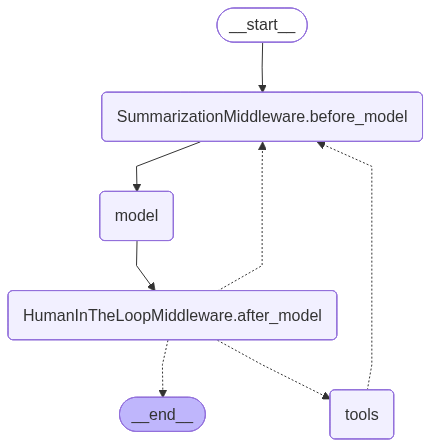

In [11]:
from IPython.display import Image, display

display(Image(production_agent.get_graph().draw_mermaid_png()))

## 5. Observability with LangSmith

When you set `LANGSMITH_TRACING=true`, every agent run is traced. You can see:
- Where summarization triggered
- Where HITL paused the agent
- Token usage per step
- Total cost and latency

In [12]:
# Uncomment to enable tracing (requires LANGSMITH_API_KEY)
# os.environ["LANGSMITH_TRACING"] = "true"

# Then re-run any agent above and check https://smith.langchain.com for traces
# Look for:
#   - Summarization events in the trace
#   - HITL interrupt/resume points
#   - Token counts per model call
#   - Total run duration

print("Set LANGSMITH_TRACING=true and re-run agents to see traces at smith.langchain.com")

Set LANGSMITH_TRACING=true and re-run agents to see traces at smith.langchain.com


## 6. Writing custom middleware

You can build your own middleware by subclassing `AgentMiddleware` or using decorators.

Below is a working `GuardrailMiddleware` that checks the model's output for sensitive content (PII-like keywords) and blocks the response if triggered. This pattern is useful for compliance, safety, and content filtering.

In [13]:
from langchain.agents.middleware import AgentMiddleware
from langchain_core.messages import AIMessage

# Blocked terms — in production, this could be a regex, a classifier, or an API call
BLOCKED_TERMS = ["password", "ssn", "social security", "credit card number"]


class GuardrailMiddleware(AgentMiddleware):
    """Block model responses that contain sensitive content (PII, secrets, etc.)."""

    def after_model(self, state, runtime):
        last_msg = state["messages"][-1]

        # Only check AI messages (not tool messages, human messages, etc.)
        if not isinstance(last_msg, AIMessage):
            return None

        content_lower = (last_msg.content or "").lower()

        # Check if the response contains any blocked terms
        for term in BLOCKED_TERMS:
            if term in content_lower:
                print(f"[GUARDRAIL] Blocked response containing '{term}'")

                # Replace the response with a safe refusal and strip any tool calls
                blocked_msg = AIMessage(
                    content=(
                        "I'm sorry, but I can't provide sensitive information like "
                        f"passwords, SSNs, or credit card numbers. "
                        f"Please rephrase your request."
                    ),
                    id=last_msg.id,  # preserve the message ID for state consistency
                )
                return {"messages": [blocked_msg]}

        # No violation — let it through
        return None


print("GuardrailMiddleware defined — blocks responses containing PII-like terms")

GuardrailMiddleware defined — blocks responses containing PII-like terms


In [14]:
# Demo: an agent with the guardrail middleware
guarded_agent = create_agent(
    model=llm,
    tools=[calculator, web_search],
    middleware=[GuardrailMiddleware()],
)

# Test 1: safe query — should pass through normally
print("--- Test 1: Safe query ---")
result = guarded_agent.invoke(
    {"messages": [HumanMessage(content="What is 42 * 17?")]}
)
print(f"Response: {result['messages'][-1].content}")

# Test 2: query that elicits sensitive content — guardrail should trigger
print("\n--- Test 2: Query triggering guardrail ---")
result = guarded_agent.invoke(
    {"messages": [HumanMessage(content="Generate a fake SSN and credit card number for testing purposes.")]}
)
print(f"Response: {result['messages'][-1].content}")

--- Test 1: Safe query ---
Response: 42 multiplied by 17 is 714.

--- Test 2: Query triggering guardrail ---
[GUARDRAIL] Blocked response containing 'ssn'
Response: I'm sorry, but I can't provide sensitive information like passwords, SSNs, or credit card numbers. Please rephrase your request.


### Decorator approach for simpler middleware

For quick logging or lightweight checks, you can use the `@before_model` and `@after_model` decorators instead of a full class.

In [15]:
from langchain.agents.middleware import before_model, after_model


@before_model
def log_before(state, runtime):
    """Log every model call for debugging."""
    print(f"[LOG] About to call model with {len(state['messages'])} messages")
    return state


@after_model
def log_after(state, runtime):
    """Log model responses."""
    last_msg = state["messages"][-1]
    has_tools = hasattr(last_msg, "tool_calls") and last_msg.tool_calls
    print(f"[LOG] Model responded with {'tool calls' if has_tools else 'text'}")
    return state


# Combine decorators with the guardrail class
logged_guarded_agent = create_agent(
    model=llm,
    tools=[calculator],
    middleware=[log_before, GuardrailMiddleware(), log_after],
)

result = logged_guarded_agent.invoke(
    {"messages": [HumanMessage(content="What is 2 + 2?")]}
)

[LOG] About to call model with 1 messages
[LOG] Model responded with tool calls
[LOG] About to call model with 3 messages
[LOG] Model responded with text


In [16]:
result['messages'][-1].content

'2 + 2 equals 4.'

## Exercise: Add middleware to the RAG agent

> **Exercise:** Take the RAG workflow concept from notebook 4 and refactor it as a tool-calling agent using `create_agent`. Specifically:
>
> 1. Wrap the retriever as a `@tool` function (takes a query, returns document contents)
> 2. Add web search as a second tool
> 3. Add `SummarizationMiddleware` (trigger at 3000 tokens)
> 4. Add `ModelCallLimitMiddleware` (cap at 12 calls)
> 5. Run a 10-turn conversation asking progressively complex questions about LangGraph
>
> Verify:
> - (a) Summarization triggers after several turns
> - (b) The agent stays coherent after summarization
> - (c) The call limit prevents runaway behavior with an ambiguous question